In [23]:
import numpy as np
import torch

In [2]:
np.random.seed(17)  # So you can reproduce these results at home

In [3]:
nv = 20  # Number of points in each direction
xv = np.linspace(-5.,5.,nv)  # x-vector
yv = np.linspace(-5.,5.,nv)  # y-vector
x, y = np.meshgrid(xv, yv)  # x and y are (nv, nv) matrices
z = (x-3.)**2. + 2.*x*y + (2.*y+3.)**2. - 3.

In [20]:
print(z)

[[ 1.60000000e+02  1.46592798e+02  1.33739612e+02  1.21440443e+02
   1.09695291e+02  9.85041551e+01  8.78670360e+01  7.77839335e+01
   6.82548476e+01  5.92797784e+01  5.08587258e+01  4.29916898e+01
   3.56786704e+01  2.89196676e+01  2.27146814e+01  1.70637119e+01
   1.19667590e+01  7.42382271e+00  3.43490305e+00  0.00000000e+00]
 [ 1.41108033e+02  1.28254848e+02  1.15955679e+02  1.04210526e+02
   9.30193906e+01  8.23822715e+01  7.22991690e+01  6.27700831e+01
   5.37950139e+01  4.53739612e+01  3.75069252e+01  3.01939058e+01
   2.34349030e+01  1.72299169e+01  1.15789474e+01  6.48199446e+00
   1.93905817e+00 -2.04986150e+00 -5.48476454e+00 -8.36565097e+00]
 [ 1.24432133e+02  1.12132964e+02  1.00387812e+02  8.91966759e+01
   7.85595568e+01  6.84764543e+01  5.89473684e+01  4.99722992e+01
   4.15512465e+01  3.36842105e+01  2.63711911e+01  1.96121884e+01
   1.34072022e+01  7.75623269e+00  2.65927978e+00 -1.88365651e+00
  -5.87257618e+00 -9.30747922e+00 -1.21883657e+01 -1.45152355e+01]
 [ 1.09

In [22]:
noise_level = 5.
z_noisy = z + np.random.normal(size=x.shape) * noise_level

In [5]:
X = np.column_stack((x.reshape(-1), y.reshape(-1)))
Z = z_noisy.reshape(-1,1)

In [6]:
guess_l = (2., 1.)  # In general, x and y have different scales
bounds_l = ((1e-1,100.),) * 2  # Same bounds for x and y
guess_n = 1.  # Amount of noise
bounds_n = (1e-20, 10.) # Bounds for noise
kernel = (  # Kernel objects can simply be summed using +
    RBF(length_scale=guess_l, length_scale_bounds=bounds_l)
    + WhiteKernel(noise_level=guess_n, noise_level_bounds=bounds_n)
)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Z, test_size=0.95)

In [8]:
gpr = GaussianProcessRegressor(kernel, normalize_y=True )
gpr.fit(X_train, Y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=[2, 1]) + WhiteKernel(noise_level=1),
                         normalize_y=True)

In [9]:
print(gpr.kernel_)
# RBF(length_scale=[7.86, 3.71]) + WhiteKernel(noise_level=0.00678)

RBF(length_scale=[7.86, 3.71]) + WhiteKernel(noise_level=0.00678)


In [10]:
Zfit, Zstd = gpr.predict(X, return_std=True)
zstd = Zstd.reshape(x.shape)
zfit = Zfit.reshape(x.shape)

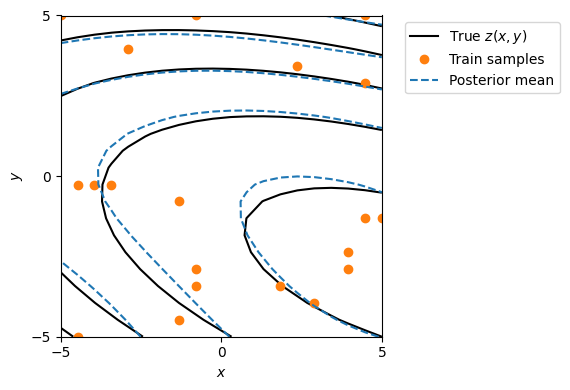

In [11]:
# Set up figure
fig, ax = plt.subplots(figsize=(6., 4.))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))
ax.set_aspect('equal')
ax.set_xticks((-5,0,5))
ax.set_yticks((-5,0,5))
ax.grid(False)

# Do the plotting
lev = np.linspace(0.,250.,6)
ax.contour(x,y,z,lev,colors='k')  # Truth
ax.plot(*X_train.T,'o',color="C1")  # Training samples
ax.contour(x, y,zfit, lev, colors='C0', linestyles='dashed')  # Posterior mean

# Legend
truth_line = mlines.Line2D([], [], color='black', label='True $z(x,y)$')
sample_line = mlines.Line2D([], [], color='C1', marker="o", linestyle="none", label='Train samples')
mean_line = mlines.Line2D([], [], color='C0', linestyle="--", label='Posterior mean')
ax.legend(handles=[truth_line, sample_line, mean_line],bbox_to_anchor=(1.05, 1), loc="upper left")

# Write out
plt.tight_layout()
plt.savefig('gpr_posterior_mean.svg')

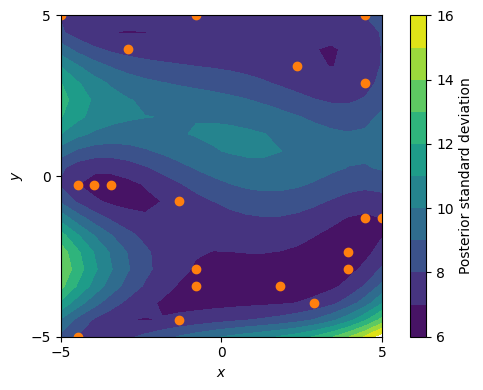

In [15]:
# Set up figure
fig, ax = plt.subplots(figsize=(6., 4.))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-5,5))
ax.set_ylim((-5,5))
ax.set_aspect('equal')
ax.set_xticks((-5,0,5))
ax.set_yticks((-5,0,5))
ax.grid(False)

# Do the plotting
ax.plot(*X_train.T,'o',color="C1")  # Training samples
lev = np.linspace(6.,16.,11)
hc = ax.contourf(x, y, zstd, lev)  # Posterior std
#for hci in hc.collections:
#  hci.set_edgecolor("face")

# Colorbar
hcb = plt.colorbar(hc)
hcb.ax.grid(False)
hcb.set_label('Posterior standard deviation')

# Write out
plt.tight_layout()
plt.savefig('gpr_posterior_std.svg')